In [1]:
# Define the configuration of the environment that will be built

env_config_dict = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'filecoin-energy',
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #   "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #   {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        # (2) Trading collectible resources
        ('BuyRECFromVirtualStore', { 'green_score_importance': 0.0, 'static': True}),
    ],
    

    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 100,          # Number of non-planner agents (must be > 1)
    'world_size': [1, 1], # [Height, Width] of the env world
    'episode_length': 336, # Number of timesteps per episode
    'static': True,
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': False,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
    'dense_log_frequency': 1
}

In [2]:
from rllib.env_wrapper import RLlibEnvWrapper
env_obj = RLlibEnvWrapper({"env_config_dict": env_config_dict}, verbose=True)

Inside covid19_components.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.
Inside covid19_env.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.


/home/ubuntu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: 

[EnvWrapper] Spaces
[EnvWrapper] Obs (a)   
action_mask    : (22,)
time           : (1,)
world-endogenous-ConsumedEnergy: (24,)
world-endogenous-EnergyPrice: (1,)
world-endogenous-GreenScore: (1,)
world-endogenous-GreenScoresLastDay: (24,)
world-endogenous-InitialGreenScore: (1,)
world-endogenous-NewData: (1,)
world-endogenous-RECsPrice: (1,)
world-endogenous-ReliabilityScore: (1,)
world-endogenous-TotalData: (1,)
world-endogenous-TotalScore: (1,)


[EnvWrapper] Obs (p)   
action_mask    : (1,)


[EnvWrapper] Action (a) Discrete(22)
[EnvWrapper] Action (p) Discrete(1)


In [3]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

In [4]:
policies = {
    "a": (
        None,  # uses default policy
        env_obj.observation_space,
        env_obj.action_space,
        {}  # define a custom agent policy configuration.
    ),
    "p": (
        None,  # uses default policy
        env_obj.observation_space_pl,
        env_obj.action_space_pl,
        {}  # define a custom planner policy configuration.
    )
}

# In foundation, all the agents have integer ids and the social planner has an id of "p"
policy_mapping_fun = lambda i: "a" if str(i).isdigit() else "p"

policies_to_train = ["a", "p"]

In [5]:
trainer_config = {
    "multiagent": {
        "policies": policies,
        "policies_to_train": policies_to_train,
        "policy_mapping_fn": policy_mapping_fun,
    }
}

In [6]:
trainer_config.update(
    {
        "num_workers": 2,
        "num_envs_per_worker": 2,
        # Other training parameters
        "train_batch_size":  4000,
        "sgd_minibatch_size": 4000,
        "num_sgd_iter": 1,
        "lr": 0.00001,
    }
)

In [7]:
# We also add the "num_envs_per_worker" parameter for the env. wrapper to index the environments.
env_config = {
    "env_config_dict": env_config_dict,
    "num_envs_per_worker": trainer_config.get('num_envs_per_worker'),   
}

trainer_config.update(
    {
        "env_config": env_config        
    }
)

In [8]:
# Initialize Ray
ray.init(webui_host="127.0.0.1")

2022-06-01 09:21:51,903	INFO resource_spec.py:212 -- Starting Ray with 9.13 GiB memory available for workers and up to 4.57 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2022-06-01 09:21:52,561	INFO services.py:1148 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '172.31.29.14',
 'redis_address': '172.31.29.14:38913',
 'object_store_address': '/tmp/ray/session_2022-06-01_09-21-51_888393_1954/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-06-01_09-21-51_888393_1954/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2022-06-01_09-21-51_888393_1954'}

In [9]:
# Create the PPO trainer.
trainer = PPOTrainer(
    env=RLlibEnvWrapper,
    config=trainer_config,
    )

2022-06-01 09:21:53,244	INFO trainer.py:428 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2022-06-01 09:21:53,327	INFO trainer.py:585 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=2014) /home/ubuntu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=2014)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=2014) /home/ubuntu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=2014)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=2014) /home/ubuntu/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=2014)   _np_qint16 = np.dtype([("qint16", np.int16, 1)])
(pid=2014) /home/ubuntu/.

(pid=2014) Inside covid19_components.py: 0 GPUs are available.
(pid=2014) No GPUs found! Running the simulation on a CPU.
(pid=2014) Inside covid19_env.py: 0 GPUs are available.
(pid=2014) No GPUs found! Running the simulation on a CPU.
(pid=2012) Inside covid19_components.py: 0 GPUs are available.
(pid=2012) No GPUs found! Running the simulation on a CPU.
(pid=2012) Inside covid19_env.py: 0 GPUs are available.
(pid=2012) No GPUs found! Running the simulation on a CPU.


2022-06-01 09:22:03,584	INFO trainable.py:180 -- _setup took 10.258 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-06-01 09:22:03,584	INFO trainable.py:217 -- Getting current IP.


In [10]:
NUM_ITERS = 50
for iteration in range(NUM_ITERS):
    print(f'********** Iter : {iteration} **********')
    result = trainer.train()
    print(f'''episode_reward_mean: {result.get('episode_reward_mean')}''')

********** Iter : 0 **********
(pid=2014) 2022-06-01 09:22:06,913	WARNING sampler.py:404 -- More than 2020 observations for 21 env steps are buffered in the sampler. If this is more than you expected, check that that you set a horizon on your environment correctly and that it terminates at some point. Note: In multi-agent environments, `rollout_fragment_length` sets the batch size based on environment steps, not the steps of individual agents, which can result in unexpectedly large batches. Also, you may be in evaluation waiting for your Env to terminate (batch_mode=`complete_episodes`). Make sure it does at some point.
episode_reward_mean: 366.9016107866969
********** Iter : 1 **********
episode_reward_mean: 366.95443770593096
********** Iter : 2 **********
episode_reward_mean: 366.93564053920204
********** Iter : 3 **********
episode_reward_mean: 366.9205303152104
********** Iter : 4 **********
episode_reward_mean: 366.9203711500739
********** Iter : 5 **********
episode_reward_mean:

In [11]:
env_obj.env.get_agent(3).state

{'loc': [-1, -1],
 'inventory': {},
 'escrow': {},
 'endogenous': {'ConsumedEnergy': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]),
  'GreenScore': 0.6888900000000001,
  'GreenScoresLastDay': array([0.68889, 0.68889, 0.68889, 0.68889, 0.68889, 0.68889, 0.68889,
         0.68889, 0.68889, 0.68889, 0.68889, 0.68889, 0.68889, 0.68889,
         0.68889, 0.68889, 0.68889, 0.68889, 0.68889, 0.68889, 0.68889,
         0.68889, 0.68889, 0.68889]),
  'NewData': 0.0,
  'RECsPrice': 0.0,
  'TotalData': 0.0,
  'ReliabilityScore': 0.3,
  'TotalScore': 0.3,
  'EnergyPrice': 0.115,
  'InitialGreenScore': 0.68889}}

In [12]:
def generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=1
):
    dense_logs = {}
    for idx in range(num_dense_logs):
        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()   

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        for t in range(env_obj.env.episode_length):
            actions = {}
            for agent_idx in range(env_obj.env.n_agents):
                # Use the trainer object directly to sample actions for each agent
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)], 
                    agent_states[str(agent_idx)], 
                    policy_id="a",
                    full_fetch=False
                )

            # Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs['p'], 
                planner_states, 
                policy_id='p',
                full_fetch=False
            )

            obs, rew, done, info = env_obj.step(actions)        
            if done['__all__']:
                break
        dense_logs[idx] = env_obj.env.dense_log
    return dense_logs

In [13]:
dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=1
)

In [14]:
timesteps = len(dense_logs[0]['states'])

In [15]:
import numpy as np

In [16]:
avg_green_scores = [np.mean(np.array([dense_logs[0]['states'][i][k]['endogenous']['GreenScore'] for k in dense_logs[0]['states'][i].keys() if k != 'p'])) for i in range(0,timesteps)]

In [17]:
def reliability_scores(agent_reliability_scores, agent_storage):
    if np.sum(agent_storage) == 0:
        return 0.0
    return np.sum(agent_reliability_scores * agent_storage) / np.sum(agent_storage)


def green_scores(agent_green_scores, agent_storage):
    if np.sum(agent_storage) == 0:
        return 0.0
    return np.sum(agent_green_scores * agent_storage) / np.sum(agent_storage)

In [18]:
system_greenness = []
for i in range(0,timesteps):  
    agent_green_scores = np.array(
        [dense_logs[0]['states'][i][k]['endogenous']['GreenScore'] for k in dense_logs[0]['states'][i].keys() if k != 'p']
    )
    agent_data = np.array(
        [dense_logs[0]['states'][i][k]['endogenous']['TotalData'] for k in dense_logs[0]['states'][i].keys() if k != 'p']
    )

    rel = green_scores(agent_green_scores, agent_data)
    system_greenness.append(rel)

In [19]:
system_reliability = []
for i in range(0,timesteps):  
    agent_reliability_scores = np.array(
        [dense_logs[0]['states'][i][k]['endogenous']['ReliabilityScore'] for k in dense_logs[0]['states'][i].keys() if k != 'p']
    )
    agent_data = np.array(
        [dense_logs[0]['states'][i][k]['endogenous']['TotalData'] for k in dense_logs[0]['states'][i].keys() if k != 'p']
    )

    rel = reliability_scores(agent_reliability_scores, agent_data)
    system_reliability.append(rel)

In [20]:
agent_0_green_scores = [log["0"]["endogenous"]["GreenScore"] for log in dense_logs[0]['states']]
agent_1_green_scores = [log["1"]["endogenous"]["GreenScore"] for log in dense_logs[0]['states']]
agent_2_green_scores = [log["2"]["endogenous"]["GreenScore"] for log in dense_logs[0]['states']]
agent_3_green_scores = [log["3"]["endogenous"]["GreenScore"] for log in dense_logs[0]['states']]

In [21]:
agent_0_rel_scores = [log["0"]["endogenous"]["ReliabilityScore"] for log in dense_logs[0]['states']]
agent_1_rel_scores = [log["1"]["endogenous"]["ReliabilityScore"] for log in dense_logs[0]['states']]
agent_2_rel_scores = [log["2"]["endogenous"]["ReliabilityScore"] for log in dense_logs[0]['states']]
agent_3_rel_scores = [log["3"]["endogenous"]["ReliabilityScore"] for log in dense_logs[0]['states']]

In [22]:
agent_0_score = [log["0"]["endogenous"]["TotalScore"] for log in dense_logs[0]['states']]
agent_1_score = [log["1"]["endogenous"]["TotalScore"] for log in dense_logs[0]['states']]
agent_2_score = [log["2"]["endogenous"]["TotalScore"] for log in dense_logs[0]['states']]
agent_3_score = [log["3"]["endogenous"]["TotalScore"] for log in dense_logs[0]['states']]

In [23]:
agent_0_data = [log["0"]["endogenous"]["TotalData"] for log in dense_logs[0]['states']]
agent_1_data = [log["1"]["endogenous"]["TotalData"] for log in dense_logs[0]['states']]
agent_2_data = [log["2"]["endogenous"]["TotalData"] for log in dense_logs[0]['states']]
agent_3_data = [log["3"]["endogenous"]["TotalData"] for log in dense_logs[0]['states']]

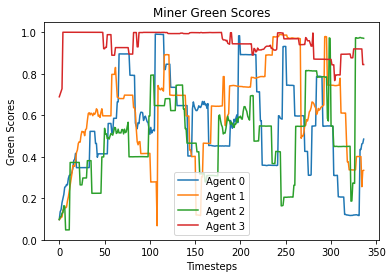

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(0,timesteps),agent_0_green_scores, label="Agent 0")
plt.plot(np.arange(0,timesteps),agent_1_green_scores, label="Agent 1")
plt.plot(np.arange(0,timesteps),agent_2_green_scores, label="Agent 2")
plt.plot(np.arange(0,timesteps),agent_3_green_scores, label="Agent 3")
plt.title('Miner Green Scores')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Green Scores')
plt.savefig("miners_green_scores_0_importance_50_epochs.png")
plt.show()

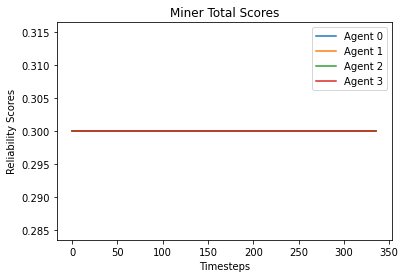

In [25]:
plt.plot(np.arange(0,timesteps),agent_0_score, label="Agent 0")
plt.plot(np.arange(0,timesteps),agent_1_score, label="Agent 1")
plt.plot(np.arange(0,timesteps),agent_2_score, label="Agent 2")
plt.plot(np.arange(0,timesteps),agent_3_score, label="Agent 3")
plt.title('Miner Total Scores')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Reliability Scores')
plt.savefig("miners_total_scores_0_importance_50_epochs.png")
plt.show()

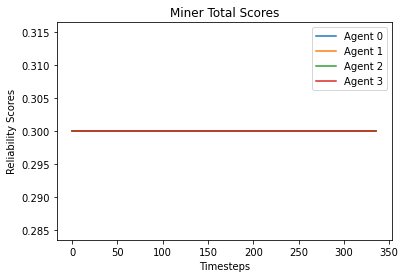

In [26]:
plt.plot(np.arange(0,timesteps),agent_0_score, label="Agent 0")
plt.plot(np.arange(0,timesteps),agent_1_score, label="Agent 1")
plt.plot(np.arange(0,timesteps),agent_2_score, label="Agent 2")
plt.plot(np.arange(0,timesteps),agent_3_score, label="Agent 3")
plt.title('Miner Total Scores')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Reliability Scores')
plt.savefig("miners_total_scores_0_importance_50_epochs.png")
plt.show()

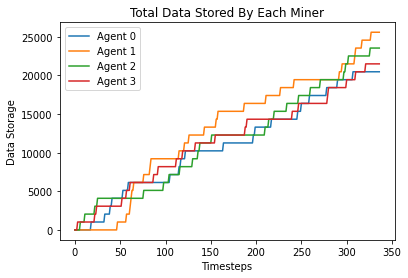

In [27]:
plt.plot(np.arange(0,timesteps),agent_0_data, label="Agent 0")
plt.plot(np.arange(0,timesteps),agent_1_data, label="Agent 1")
plt.plot(np.arange(0,timesteps),agent_2_data, label="Agent 2")
plt.plot(np.arange(0,timesteps),agent_3_data, label="Agent 3")
plt.title('Total Data Stored By Each Miner')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Data Storage')
plt.savefig("miners_data_stored_0_importance_50_epochs.png")
plt.show()

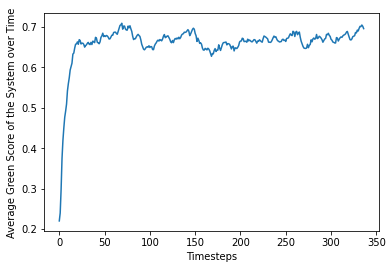

In [28]:
plt.plot(np.arange(0,timesteps),avg_green_scores)
plt.xlabel('Timesteps')
plt.ylabel('Average Green Score of the System over Time')
plt.savefig("avg_miner_green_score_0_importance_50_epochs.png")
plt.show()

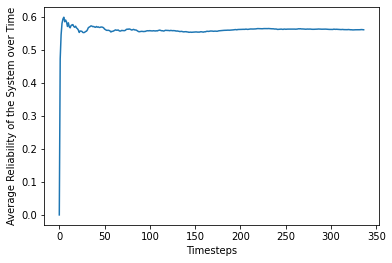

In [29]:
plt.plot(np.arange(0,timesteps),system_reliability)
plt.xlabel('Timesteps')
plt.ylabel('Average Reliability of the System over Time')
plt.savefig("system_reliability_0_importance_50_epochs.png")
plt.show()

In [34]:
system_greenness

[0.0,
 0.19771675925925924,
 0.4217455043859649,
 0.6304851284673005,
 0.6542907372908616,
 0.6809801278976041,
 0.6545965175835797,
 0.6379466514322696,
 0.61915689286553,
 0.650934045120464,
 0.6596054174549199,
 0.6610970783451141,
 0.6661606310967122,
 0.6699264005893374,
 0.6569220041462321,
 0.6676385183121312,
 0.6698836174919914,
 0.6713828464308784,
 0.6757432272148888,
 0.6780393742061751,
 0.6839665097189123,
 0.6689941262442166,
 0.6760404343826597,
 0.6682888455275743,
 0.6572829196328207,
 0.6625539437387358,
 0.6583136036859351,
 0.6536574463834682,
 0.6440583061430774,
 0.642962817780098,
 0.6451962829088398,
 0.6551089935181383,
 0.6589579514622048,
 0.6528332742523325,
 0.6508086795698953,
 0.6570941100955767,
 0.6448112258617393,
 0.6533019661632157,
 0.6539774290872763,
 0.6521042489983995,
 0.663664528423315,
 0.6586356659908447,
 0.652447944482374,
 0.6494943246538725,
 0.650333550116636,
 0.6607998670643243,
 0.6692191817046659,
 0.6707814848581789,
 0.6778016321

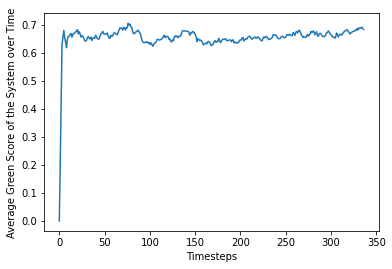

In [31]:
plt.plot(np.arange(0,timesteps),system_greenness)
plt.xlabel('Timesteps')
plt.ylabel('Average Green Score of the System over Time')
plt.savefig("system_greenness_0_importance_50_epochs.png")
plt.show()

In [32]:
dense_logs[0]['actions'][167]

{'0': {'BuyRecFromVirtualStore': 1},
 '1': {'BuyRecFromVirtualStore': 12},
 '2': {'BuyRecFromVirtualStore': 17},
 '3': {'BuyRecFromVirtualStore': 8},
 '4': {'BuyRecFromVirtualStore': 20},
 '5': {},
 '6': {'BuyRecFromVirtualStore': 2},
 '7': {'BuyRecFromVirtualStore': 17},
 '8': {'BuyRecFromVirtualStore': 6},
 '9': {'BuyRecFromVirtualStore': 5},
 '10': {'BuyRecFromVirtualStore': 12},
 '11': {'BuyRecFromVirtualStore': 19},
 '12': {'BuyRecFromVirtualStore': 21},
 '13': {'BuyRecFromVirtualStore': 21},
 '14': {'BuyRecFromVirtualStore': 15},
 '15': {'BuyRecFromVirtualStore': 11},
 '16': {'BuyRecFromVirtualStore': 21},
 '17': {'BuyRecFromVirtualStore': 18},
 '18': {'BuyRecFromVirtualStore': 6},
 '19': {'BuyRecFromVirtualStore': 19},
 '20': {'BuyRecFromVirtualStore': 20},
 '21': {'BuyRecFromVirtualStore': 11},
 '22': {'BuyRecFromVirtualStore': 2},
 '23': {'BuyRecFromVirtualStore': 17},
 '24': {},
 '25': {},
 '26': {'BuyRecFromVirtualStore': 18},
 '27': {'BuyRecFromVirtualStore': 21},
 '28': {'

In [33]:
# Shutdown Ray after use
ray.shutdown()